# Fourier-Transform

<a id='sec2'></a>
## Numerical inversion


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.integrate import quad
from functools import partial # for passing parameters to quad
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d

from FMNM.BS_pricer import BS_pricer
from FMNM.Parameters import Option_param
from FMNM.Processes import Merton_process
from FMNM.Merton_pricer import Merton_pricer
from FMNM.Processes import VG_process
from FMNM.VG_pricer import VG_pricer

In [2]:
def cf_normal(u, mu=1, sig=2): # Characteristic function of a normal distribution
    return np.exp(1j * u * mu - 0.5 * u**2 * sig**2)

In [3]:
def cf_gamma(u, a=1, b=2): # Characteristic function of a gamma distribution
    return (1 - b * u * 1j) ** (-a)

In [4]:
def cf_poisson(u, lam=1): # Characteristic function of a Poisson distribution
    return np.exp(lam * (np.exp(1j * u) - 1))

In [5]:
# Gil Pelaez formula for the density
# right_lim is the right extreme of integration
# cf is the characteristic function
def Gil_Pelaez_pdf(x, cf, right_lim):
    integrand = lambda u: np.real(np.exp(-u * x * 1j) * cf(u))
    return 1 / np.pi * quad(integrand, 1e-15, right_lim)[0]

### Normal

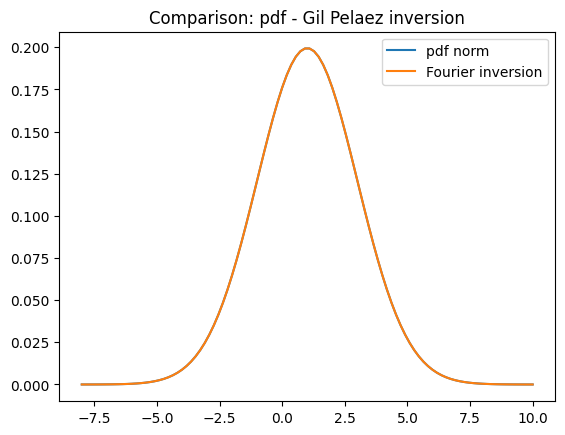

In [6]:
x = np.linspace(-8, 10, 100)
plt.plot(x, ss.norm.pdf(x, loc=1, scale=2), label="pdf norm")
plt.plot(x, [Gil_Pelaez_pdf(i, cf_normal, np.inf) for i in x], label="Fourier inversion")
plt.title("Comparison: pdf - Gil Pelaez inversion")
plt.legend()
plt.show()

### Gamma

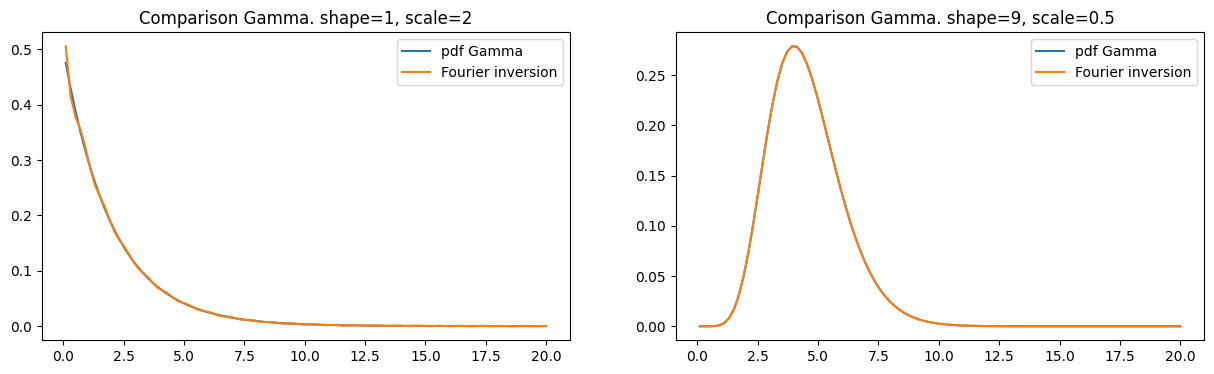

In [7]:
xx = np.linspace(0.1, 20, 100)
a = 1  # shape parameter
b = 2  # scale parameter
c = 9  # shape parameter
d = 0.5  # scale parameter
lim_ab = 24
lim_cd = np.inf
cf_gamma_ab = partial(cf_gamma, a=a, b=b)  # function binding
cf_gamma_cd = partial(cf_gamma, a=c, b=d)  # function binding

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(xx, ss.gamma.pdf(xx, a, scale=b), label="pdf Gamma")
ax1.plot(xx, [Gil_Pelaez_pdf(i, cf_gamma_ab, lim_ab) for i in xx], label="Fourier inversion")
ax1.set_title("Comparison Gamma. shape=1, scale=2")
ax1.legend()
ax2.plot(xx, ss.gamma.pdf(xx, c, scale=d), label="pdf Gamma")
ax2.plot(xx, [Gil_Pelaez_pdf(i, cf_gamma_cd, lim_cd) for i in xx], label="Fourier inversion")
ax2.set_title("Comparison Gamma. shape=9, scale=0.5")
ax2.legend()
plt.show()

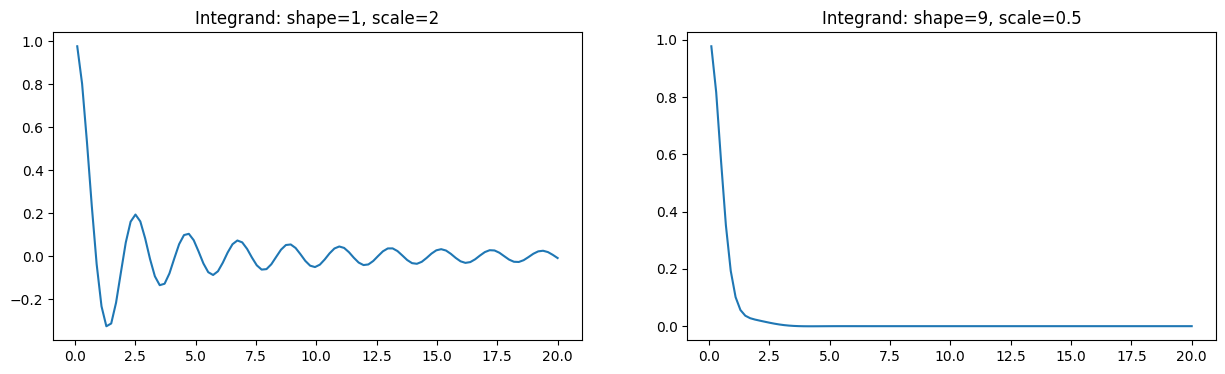

In [8]:
u = np.linspace(0.1, 20, 100)
x = 3
f = lambda u: np.real(np.exp(-u * x * 1j) * cf_gamma_ab(u))  # integrand
g = lambda u: np.real(np.exp(-u * x * 1j) * cf_gamma_cd(u))

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(u, f(u))
ax1.set_title("Integrand: shape=1, scale=2")
ax2.plot(u, g(u))
ax2.set_title("Integrand: shape=9, scale=0.5")
plt.show()

### Poisson

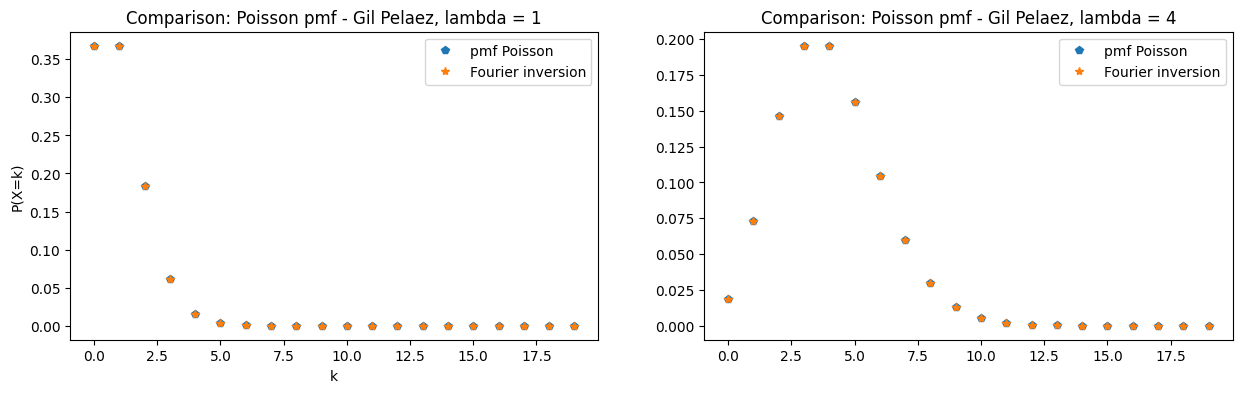

In [9]:
k = np.array(range(20))
lam = 4
cf_poisson4 = partial(cf_poisson, lam=lam)  # function binding to lam=4

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(k, ss.poisson.pmf(k, 1), linestyle="None", marker="p", label="pmf Poisson")  # with lam=1
ax1.plot(
    k, [Gil_Pelaez_pdf(i, cf_poisson, np.pi) for i in k], linestyle="None", marker="*", label="Fourier inversion"
)  # lam=1 by default
ax1.set_xlabel("k")
ax1.set_ylabel("P(X=k)")
ax1.set_title("Comparison: Poisson pmf - Gil Pelaez, lambda = 1")
ax1.legend()
ax2.plot(k, ss.poisson.pmf(k, lam), linestyle="None", marker="p", label="pmf Poisson")
ax2.plot(k, [Gil_Pelaez_pdf(i, cf_poisson4, np.pi) for i in k], linestyle="None", marker="*", label="Fourier inversion")
ax2.set_title("Comparison: Poisson pmf - Gil Pelaez, lambda = 4")
ax2.legend()
plt.show()

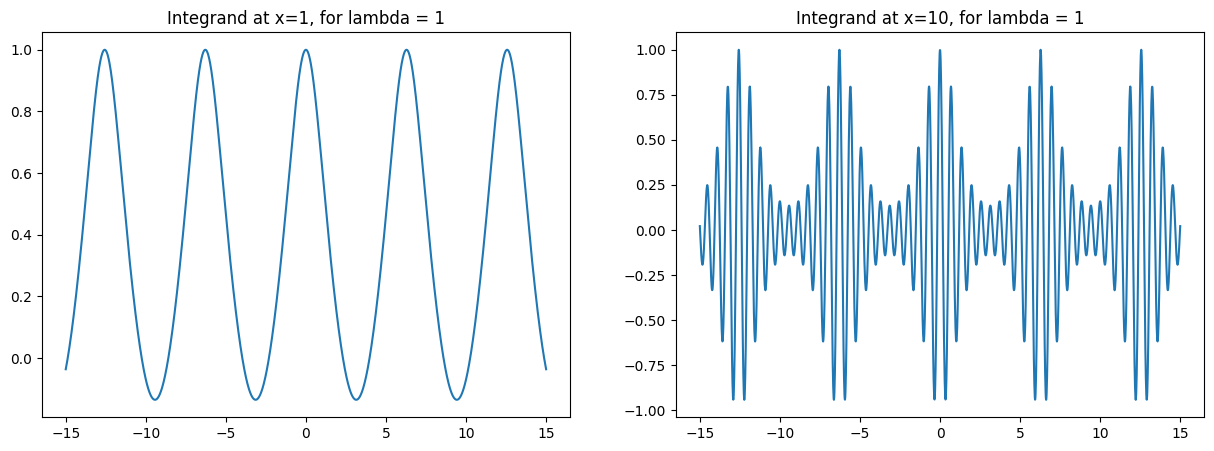

In [10]:
X1 = 1 
X2 = 10 
y = np.linspace(0.0 - 15, 15, 2000)
ff = lambda u: np.real(np.exp(-u * X1 * 1j) * cf_poisson(u))  # integrand
gg = lambda u: np.real(np.exp(-u * X2 * 1j) * cf_poisson(u))  # integrand

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(y, ff(y))
ax1.set_title("Integrand at x=1, for lambda = 1")
ax2.plot(y, gg(y))
ax2.set_title("Integrand at x=10, for lambda = 1")
plt.show()

## Option pricing

In [11]:
def Q1(k, cf, right_lim): # cdf for Q1 which is the probability that X < k
    integrand = lambda u: np.real((np.exp(-u * k * 1j) / (u * 1j)) * cf(u - 1j) / cf(-1j))
    return 1 / 2 + 1 / np.pi * quad(integrand, 1e-15, right_lim, limit=1000)[0]

In [12]:
def Q2(k, cf, right_lim): # cdf for Q2 which is the probability that X > k
    integrand = lambda u: np.real(np.exp(-u * k * 1j) / (u * 1j) * cf(u))
    return 1 / 2 + 1 / np.pi * quad(integrand, 1e-15, right_lim, limit=1000)[0]

In the following, we present European Call Option Values, with the following parameters:

In [13]:
S0 = 100.0  # spot stock price
K = 100.0  # strike
T = 1  # maturity
k = np.log(K / S0)  # log moneyness

### Geometric Brownian motion

In [14]:
r = 0.1  # risk free rate
sig = 0.2  # volatility

In [15]:
cf_GBM = partial(cf_normal, mu=(r - 0.5 * sig**2) * T, sig=sig * np.sqrt(T)) 
# function binding
call_BS = S0 * Q1(k, cf_GBM, np.inf) - K * np.exp(-r * T) * Q2(k, cf_GBM, np.inf) 
# pricing function

print("Fourier inversion call: ", call_BS)
print("Closed formula call: ", BS_pricer.BlackScholes("call", S0, K, T, r, sig))

Fourier inversion call:  13.2696765846609
Closed formula call:  13.269676584660893


### Merton process

In [16]:
# characteristic function of the Merton process at time t
def cf_mert(u, t=1, mu=1, sig=2, lam=0.8, muJ=0, sigJ=0.5):
    return np.exp(
        t * (1j * u * mu - 0.5 * u**2 * sig**2 + lam * (np.exp(1j * u * muJ - 0.5 * u**2 * sigJ**2) - 1))
    )

In [17]:
r = 0.1  # risk free rate
sig = 0.2  # diffusion coefficient
lam = 0.8  # jump activity
muJ = 0  # jump mean size
sigJ = 0.5  # jump std deviation
m = lam * (np.exp(muJ + (sigJ**2) / 2) - 1)  # martingale correction

# Creates the pricer objects
opt_param = Option_param(S0=S0, K=K, T=T, exercise="European", payoff="call")
Merton_param = Merton_process(r=r, sig=sig, lam=lam, muJ=muJ, sigJ=sigJ)
Merton = Merton_pricer(opt_param, Merton_param)

In [18]:
# function binding
cf_Mert = partial(cf_mert, t=T, mu=(r - 0.5 * sig**2 - m), sig=sig, lam=lam, muJ=muJ, sigJ=sigJ)
# call price
call_Mert = S0 * Q1(k, cf_Mert, np.inf) - K * np.exp(-r * T) * Q2(k, cf_Mert, np.inf)  # pricing function

print("Fourier inversion call: ", call_Mert)
print("Closed formula call: ", Merton.closed_formula())

Fourier inversion call:  22.0163676219057
Closed formula call:  22.016367621905697


### Variance Gamma

In [19]:
# characteristic function of the VG process at time t, with an additional drift mu
def cf_VG(u, t=1, mu=0, theta=-0.1, sigma=0.2, kappa=0.1):
    return np.exp(t * (1j * mu * u - np.log(1 - 1j * theta * kappa * u + 0.5 * kappa * sigma**2 * u**2) / kappa))

In [20]:
# Creates the object with the parameters of the process
VG_param = VG_process(r=0.1, sigma=0.2, theta=-0.1, kappa=0.1)
# Creates the VG process
VG = VG_pricer(opt_param, VG_param)

theta = -0.1
sigma = 0.2
kappa = 0.1  # VG parameters
w = -np.log(1 - theta * kappa - kappa / 2 * sigma**2) / kappa  # martingale correction w

In [21]:
# function binding
cf_VG_b = partial(cf_VG, t=T, mu=r - w, theta=theta, sigma=sigma, kappa=kappa)
# call price
call_VG = S0 * Q1(k, cf_VG_b, np.inf) - K * np.exp(-r * T) * Q2(k, cf_VG_b, np.inf)  # pricing function

print("Fourier inversion call: ", call_VG.round(6))
print("Monte Carlo call: {0[0]:.6f} with standard error: {1[0]:.6f}".format(*VG.MC(N=50000000, Err=True)))

Fourier inversion call:  13.314022
Monte Carlo call: 13.312545 with standard error: 0.002252


Strike= 105.0
Fourier inversion Black-Scholes call:  0.005750947197636358
BS Closed formula call:  0.005750947197631251
Strike= 120.0
Fourier inversion Black-Scholes call:  1.8860475401450416e-14
BS Closed formula call:  1.4557223869346492e-20


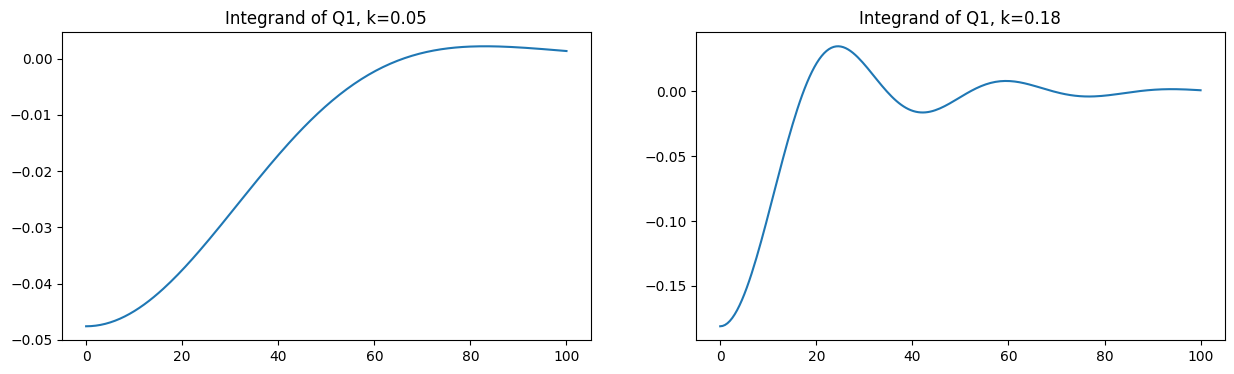

In [22]:
S0 = 100.0 # spot stock price
K1 = 105.0 # strike 1
K2 = 120.0 # strike 2
T_1 = 0.01 # maturity
k1 = np.log(K1 / S0) # moneyness 1
k2 = np.log(K2 / S0)  # moneyness 2
cf_GBM_1 = partial(cf_normal, mu=(r - 0.5 * sig**2) * T_1, sig=sig * np.sqrt(T_1))
call1 = S0 * Q1(k1, cf_GBM_1, np.inf) - K1 * np.exp(-r * T_1) * Q2(k1, cf_GBM_1, np.inf)
# pricing function 1
print("Strike=", K1)
print("Fourier inversion Black-Scholes call: ", call1)
print("BS Closed formula call: ", BS_pricer.BlackScholes("call", S0, K1, T_1, r, sig))
call2 = S0 * Q1(k2, cf_GBM_1, np.inf) - K2 * np.exp(-r * T_1) * Q2(k2, cf_GBM_1, np.inf)
# pricing function 2
print("Strike=", K2)
print("Fourier inversion Black-Scholes call: ", call2)
print("BS Closed formula call: ", BS_pricer.BlackScholes("call", S0, K2, T_1, r, sig))

u = np.linspace(1e-15, 100, 200)
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(u, np.real((np.exp(-u * k1 * 1j) / (u * 1j)) * cf_GBM_1(u - 1j) / cf_GBM_1(-1j)))
ax2.plot(u, np.real((np.exp(-u * k2 * 1j) / (u * 1j)) * cf_GBM_1(u - 1j) / cf_GBM_1(-1j)))
ax1.set_title("Integrand of Q1, k={0:0.2f}".format(k1))
ax2.set_title("Integrand of Q1, k={0:0.2f}".format(k2))
plt.show()

# Lewis Method

In [23]:
# Numerical integration of the Lewis expression
# K = strike
# cf = characteristic function

def Lewis(K, cf):
    k = np.log(S0 / K)
    integrand = lambda u: np.real(np.exp(u * k * 1j) * cf(u - 0.5j)) * 1 / (u**2 + 0.25)
    int_value = quad(integrand, 0, 2000, limit=1000)[0]
    return S0 - np.sqrt(S0 * K) * np.exp(-r * T) / np.pi * int_value

In [24]:
print("Black-Scholes: Lewis call: ", Lewis(100, cf_GBM))
print("Black-Scholes: Fourier inversion call: ", call_BS)
print()
print("Merton: Lewis call: ", Lewis(100, cf_Mert))
print("Merton: Fourier inversion call: ", call_Mert)
print()
print("Variance Gamma: Lewis call: ", Lewis(100, cf_VG_b))
print("Variance Gamma: Fourier inversion call: ", call_VG)

Black-Scholes: Lewis call:  13.269676584660886
Black-Scholes: Fourier inversion call:  13.2696765846609

Merton: Lewis call:  22.016367621905715
Merton: Fourier inversion call:  22.0163676219057

Variance Gamma: Lewis call:  13.314021941453163
Variance Gamma: Fourier inversion call:  13.314021941453447


# FFT-Method

In [25]:
# K = vector of strike
# S = spot price scalar
# cf = characteristic function
# interp can be cubic or linear

def fft_Lewis(K, S0, cf, interp="cubic"):
    N = 2**12  # FFT more efficient for N power of 2
    B = 200  # integration limit
    dx = B / N
    x = np.arange(N) * dx  # the final value B is excluded

    weight = np.arange(N)  # Simpson weights
    weight = 3 + (-1) ** (weight + 1)
    weight[0] = 1
    weight[N - 1] = 1

    dk = 2 * np.pi / B # Fourier frequencies
    b = N * dk / 2 # constant term
    ks = -b + dk * np.arange(N) # the final value b is excluded

    integrand = np.exp(-1j * b * np.arange(N) * dx) * cf(x - 0.5j) * 1 / (x**2 + 0.25) * weight * dx / 3
    integral_value = np.real(ifft(integrand) * N)

    if interp == "linear":
        spline_lin = interp1d(ks, integral_value, kind="linear")
        prices = S0 - np.sqrt(S0 * K) * np.exp(-r * T) / np.pi * spline_lin(np.log(S0 / K))
    elif interp == "cubic":
        spline_cub = interp1d(ks, integral_value, kind="cubic")
        prices = S0 - np.sqrt(S0 * K) * np.exp(-r * T) / np.pi * spline_cub(np.log(S0 / K))
    return prices

Let us select a set of strikes:

In [26]:
KK = np.arange(10, 201, 10)
print(KK)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200]


#### Black Scholes

In [27]:
prices_BS_cub = fft_Lewis(KK, S0, cf_GBM, interp="cubic")
prices_BS_lin = fft_Lewis(KK, S0, cf_GBM, interp="linear")

print("BS linear interp Error:", np.linalg.norm(prices_BS_lin - BS_pricer.BlackScholes("call", S0, KK, T, r, sig), 1))
print("BS cubic spline Error:", np.linalg.norm(prices_BS_cub - BS_pricer.BlackScholes("call", S0, KK, T, r, sig), 1))

BS linear interp Error: 0.06074959886988143
BS cubic spline Error: 1.998515418646929e-05


#### Merton

In [28]:
Merton_prices = np.zeros_like(KK, dtype=float)
for i in range(len(KK)):
    Merton.K = KK[i]
    Merton_prices[i] = Merton.closed_formula()

In [29]:
prices_M_cub = fft_Lewis(KK, S0, cf_Mert, interp="cubic")
prices_M_lin = fft_Lewis(KK, S0, cf_Mert, interp="linear")

print("Merton linear interpolation error:", np.linalg.norm(prices_M_lin - Merton_prices, 1))
print("Merton cubic spline error:", np.linalg.norm(prices_M_cub - Merton_prices, 1))

Merton linear interpolation error: 0.03701006818966235
Merton cubic spline error: 1.013697491814014e-05


#### Variance Gamma

In [30]:
VG_prices = np.zeros_like(KK, dtype=float)
for i in range(len(KK)):
    VG.K = KK[i]
    VG_prices[i] = VG.Fourier_inversion()

In [31]:
prices_VG_cub = fft_Lewis(KK, S0, cf_VG_b, interp="cubic")

In [32]:
print("VG cubic spline error:", np.linalg.norm(prices_VG_cub - VG_prices, 1))

VG cubic spline error: 2.3181008863115693e-05


### Performances:

When we want to price several options with same maturity (let's say, more than 10) the FFT method is the best.

In [33]:
%%timeit
VG_prices = np.zeros_like(KK, dtype=float)
for i in range(len(KK)):
    VG.K = KK[i]
    VG_prices[i] = VG.Fourier_inversion()

367 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%%timeit
prices_VG_cub = fft_Lewis(KK, S0, cf_VG_b, interp="cubic")

4.31 ms ± 292 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
